Device check

In [ ]:
!nvidia-smi

Sun Aug  3 12:17:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset downloading

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# !pip install -q datasets
# !pip install roboflow

In [ ]:
# from torchvision.datasets import VOCDetection
from torchvision.ops import generalized_box_iou as torch_giou
from torch.utils.data import random_split
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import torch.nn as nn
import json
import torch
import math
import os

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 800)),   # Resize shorter side to 800, keep aspect ratio
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, annotations_file, transforms=None) -> None:
    """
    Dataset for Image Data.

    Args:
        data_dir (str): Directory containing the image files.
        annotations_file (str): Path to the annotations file for supervised tasks.
        transforms (callable, optional): Optional transformations to be applied on images.
    """
    self.img_dir = data_dir
    with open(annotations_file) as f:
      coco = json.load(f)
    self.transforms = transforms
    self.images = coco['images']
    self.annotations = coco['annotations']
    self.categories = coco['categories']

    # Build image_id -> annotations mapping
    self.img_id_to_ann = {}
    for ann in self.annotations:
        img_id = ann['image_id']
        if img_id not in self.img_id_to_ann:
            self.img_id_to_ann[img_id] = []
        self.img_id_to_ann[img_id].append(ann)

    # Optional: map category_id to category name (if needed)
    self.cat_id_to_name = {cat['id']: cat['name'] for cat in self.categories}

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img_info = self.images[idx]
      img_id = img_info['id']
      img_filename = img_info['file_name']
      img_path = os.path.join(self.img_dir, img_filename)

      # Load image
      image = Image.open(img_path).convert("RGB")
      orig_w, orig_h = image.size
      # Get annotations for this image
      anns = self.img_id_to_ann.get(img_id, [])
      boxes = []
      labels = []
      for ann in anns:
          x, y, w, h = ann['bbox']
          x_min = x / orig_w
          y_min = y / orig_h
          x_max = (x + w) / orig_w
          y_max = (y + h) / orig_h
          boxes.append([x_min, y_min, x_max, y_max])
          labels.append(ann['category_id'])
      if len(boxes) == 0:
          boxes = torch.empty((0, 4), dtype=torch.float32)
          labels = torch.empty((0,), dtype=torch.long)
      else:
          boxes = torch.tensor(boxes, dtype=torch.float32)
          labels = torch.tensor(labels, dtype=torch.long)

        # for ann in anns:
        #   x, y, w, h = ann['bbox']
        #   boxes.append([x, y, x + w, y + h])
        #   labels.append(ann['category_id'])

        # Convert to tensor
        # boxes = torch.tensor(boxes, dtype=torch.float32)
        # labels = torch.tensor(labels, dtype=torch.int64)


      if self.transforms:
        image = self.transforms(image)
        # new_w, new_h = image.shape[2], image.shape[1]
        # scale_x = new_w / orig_w
        # scale_y = new_h / orig_h
        # boxes[:, [0, 2]] *= scale_x
        # boxes[:, [1, 3]] *= scale_y


      target = {
          'boxes': boxes,         # normalized
          'labels': labels,
          'image_id': torch.tensor([img_id])
      }

      return image, target

In [ ]:
# # Load VOC 2012 training set
# dataset = VOCDetection(root='./VOCdevkit/', year='2012', image_set='train', download=True, transform=transform)

# # Total size
# total_size = len(dataset)

# # Define split sizes
# train_size = int(0.8 * total_size)
# test_size = total_size - train_size

# # Randomly split dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # Check lengths
# print(f"Train size: {len(train_dataset)}")
# print(f"Test size: {len(test_dataset)}")


In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

# print("Path to dataset files:", path)

In [ ]:
# # VOC class name mapping
# VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
#                'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
#                'dog', 'horse', 'motorbike', 'person', 'pottedplant',
#                'sheep', 'sofa', 'train', 'tvmonitor']

# def voc_to_tensor(annotation):
#     size = annotation['size']
#     w = int(size['width'])
#     h = int(size['height'])

#     objects = annotation['object']
#     if not isinstance(objects, list):
#         objects = [objects]

#     target_labels = []
#     target_boxes = []

#     for obj in objects:
#         class_name = obj['name']
#         class_idx = VOC_CLASSES.index(class_name)

#         box = obj['bndbox']
#         xmin = float(box['xmin']) / w
#         ymin = float(box['ymin']) / h
#         xmax = float(box['xmax']) / w
#         ymax = float(box['ymax']) / h

#         # Convert to cx, cy, w, h
#         cx = (xmax + xmin) / 2
#         cy = (ymax + ymin) / 2
#         bw = xmax - xmin
#         bh = ymax - ymin

#         target_labels.append(class_idx)
#         target_boxes.append([cx, cy, bw, bh])

#     return torch.tensor(target_labels), torch.tensor(target_boxes)


In [ ]:
# from torchvision.datasets import VOCDetection

# class VOCWrapper(torch.utils.data.Dataset):
#     def __init__(self, root, year, image_set, transform=None, target_transform=None):
#         self.voc = VOCDetection(root=root, year=year, image_set=image_set, download=True)
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.voc)

#     def __getitem__(self, idx):
#         image, annotation = self.voc[idx]
#         # Unwrap the 'annotation' key before passing to voc_to_tensor
#         labels, boxes = voc_to_tensor(annotation['annotation'])

#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             labels, boxes = self.target_transform(labels, boxes)

#         # Return image and a dict of target tensors (labels and boxes)
#         target = {
#             'labels': labels,
#             'boxes': boxes
#         }
#         return image, target


In [ ]:
# # Example annotation dictionary from VOC

# # Convert VOC to tensor
# target_labels, target_boxes = voc_to_tensor(target['annotation'])
# target_labels, target_boxes


In [ ]:
# import matplotlib.pyplot as plt

# # Display the image
# plt.imshow(img)
# plt.title(target['annotation']['filename'])
# plt.axis('off')
# plt.show()

turn datasets into dataloaders

pay attention: each element in list of batch should be of equal size
This comes from torch.utils.data.DataLoader's default collate function, which assumes that all targets in the batch are the same size/structure — but in object detection (like PASCAL VOC), each image may have a different number of objects.

So you can't just stack the target dicts — they're too variable.



🧩 What collate_fn Does in PyTorch:

The collate_fn is a function that tells the PyTorch DataLoader how to combine a list of samples into a batch.

In [ ]:
# def voc_collate_fn(batch):
#     images = torch.stack([item[0] for item in batch])  # batch of images (B, C, H, W)
#     targets = [item[1] for item in batch]              # list of dicts with 'labels' and 'boxes'
#     return images, targets


In [ ]:
# from torch.utils.data import DataLoader, random_split

# # Instantiate dataset wrapper
# dataset = VOCWrapper(root='./VOCdevkit', year='2012', image_set='train', transform=transform)

# # Split into train/test if you want
# total_size = len(dataset)
# train_size = int(0.8 * total_size)
# test_size = total_size - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # DataLoaders with collate function
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=voc_collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=voc_collate_fn)


In [ ]:
with open('/content/drive/MyDrive/my_datasets/pascal_voc_2012_coco/Pascal-VOC-2012-1/train/_annotations.coco.json', 'r') as f:
    annotations = json.load(f)

# See the type of the top-level object
print(type(annotations))

# Try printing the first few entries
print(annotations.keys())


<class 'dict'>
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


🧩 COCO Format Structure:

In [ ]:
annotations['images']

[{'id': 0,
  'license': 1,
  'file_name': '2012_004107_jpg.rf.514479ee455502d126b4540aada33375.jpg',
  'height': 360,
  'width': 372,
  'date_captured': '2021-06-17T14:35:23+00:00'},
 {'id': 1,
  'license': 1,
  'file_name': '2010_001699_jpg.rf.519e087484ecf63279b7fc8020b61f0b.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2021-06-17T14:35:23+00:00'},
 {'id': 2,
  'license': 1,
  'file_name': '2010_002044_jpg.rf.51259121f651a2a5c18927fddc306371.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2021-06-17T14:35:23+00:00'},
 {'id': 3,
  'license': 1,
  'file_name': '2011_004402_jpg.rf.519dd3ed0c97bc7a22c46d378960d545.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2021-06-17T14:35:23+00:00'},
 {'id': 4,
  'license': 1,
  'file_name': '2012_003955_jpg.rf.513ddf2851cf6bcc2ced2a08b065fc93.jpg',
  'height': 488,
  'width': 500,
  'date_captured': '2021-06-17T14:35:23+00:00'},
 {'id': 5,
  'license': 1,
  'file_name': '2012_000115_jpg.rf.51258217e25f5e019436e86

In [ ]:
annotations['annotations']


[{'id': 0,
  'image_id': 0,
  'category_id': 15,
  'bbox': [67, 57, 300, 302],
  'area': 90600,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 1,
  'category_id': 15,
  'bbox': [269, 90, 150, 284],
  'area': 42600,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 1,
  'category_id': 9,
  'bbox': [257, 83, 163, 274],
  'area': 44662,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 1,
  'category_id': 16,
  'bbox': [455, 99, 44, 69],
  'area': 3036,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 4,
  'image_id': 1,
  'category_id': 16,
  'bbox': [198, 17, 211, 140],
  'area': 29540,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 5,
  'image_id': 2,
  'category_id': 7,
  'bbox': [37, 29, 434, 298],
  'area': 129332,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 6,
  'image_id': 2,
  'category_id': 7,
  'bbox': [398, 77, 101, 165],
  'area': 16665,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 7,
  'image_id': 2,
  'category_id': 15,
  'bbo

In [ ]:
annotations['info'], annotations['licenses'], annotations['categories']

({'year': '2021',
  'version': '1',
  'description': 'Exported from roboflow.ai',
  'contributor': 'PASCAL',
  'url': 'https://public.roboflow.ai/object-detection/pascal-voc-2012',
  'date_created': '2021-06-17T14:35:23+00:00'},
 [{'id': 1,
   'url': 'https://creativecommons.org/licenses/by/4.0/',
   'name': 'CC BY 4.0'}],
 [{'id': 0, 'name': 'VOC', 'supercategory': 'none'},
  {'id': 1, 'name': 'aeroplane', 'supercategory': 'VOC'},
  {'id': 2, 'name': 'bicycle', 'supercategory': 'VOC'},
  {'id': 3, 'name': 'bird', 'supercategory': 'VOC'},
  {'id': 4, 'name': 'boat', 'supercategory': 'VOC'},
  {'id': 5, 'name': 'bottle', 'supercategory': 'VOC'},
  {'id': 6, 'name': 'bus', 'supercategory': 'VOC'},
  {'id': 7, 'name': 'car', 'supercategory': 'VOC'},
  {'id': 8, 'name': 'cat', 'supercategory': 'VOC'},
  {'id': 9, 'name': 'chair', 'supercategory': 'VOC'},
  {'id': 10, 'name': 'cow', 'supercategory': 'VOC'},
  {'id': 11, 'name': 'diningtable', 'supercategory': 'VOC'},
  {'id': 12, 'name': 'd

In [ ]:
custom_path = "/content/drive/MyDrive/my_datasets/pascal_voc_2012_coco"

In [ ]:
# os.makedirs(custom_path, exist_ok=True)

In [ ]:
#Downloading dataset

from roboflow import Roboflow
rf = Roboflow(api_key="sZB9YfMlEljysWKB5ZpO")
project = rf.workspace("jacob-solawetz").project("pascal-voc-2012")
version = project.version(1)
dataset = version.download("coco")

In [ ]:
dataset = CustomDataset(data_dir="/content/drive/MyDrive/my_datasets/pascal_voc_2012_coco/Pascal-VOC-2012-1/train",
                        annotations_file="/content/drive/MyDrive/my_datasets/pascal_voc_2012_coco/Pascal-VOC-2012-1/train/_annotations.coco.json",
                        transforms=transform)


In [ ]:
dataset[0]

(tensor([[[-1.5185, -1.5185, -1.5185,  ..., -1.0393, -1.0631, -1.0733],
          [-1.5036, -1.5036, -1.5036,  ..., -1.0393, -1.0631, -1.0733],
          [-1.4650, -1.4650, -1.4650,  ..., -1.0393, -1.0631, -1.0733],
          ...,
          [ 0.3673,  0.3720,  0.3829,  ..., -2.0473, -2.0473, -2.0473],
          [ 0.3288,  0.3350,  0.3495,  ..., -2.0241, -2.0241, -2.0241],
          [ 0.3138,  0.3206,  0.3365,  ..., -2.0152, -2.0152, -2.0152]],
 
         [[-1.4930, -1.4930, -1.4930,  ..., -1.2306, -1.2550, -1.2654],
          [-1.4838, -1.4826, -1.4797,  ..., -1.2306, -1.2550, -1.2654],
          [-1.4602, -1.4558, -1.4457,  ..., -1.2306, -1.2550, -1.2654],
          ...,
          [ 0.6275,  0.6323,  0.6435,  ..., -1.8409, -1.8409, -1.8409],
          [ 0.5881,  0.5945,  0.6093,  ..., -1.8173, -1.8173, -1.8173],
          [ 0.5728,  0.5797,  0.5960,  ..., -1.8081, -1.8081, -1.8081]],
 
         [[-1.7347, -1.7347, -1.7347,  ..., -1.7698, -1.7941, -1.8044],
          [-1.7225, -1.7219,

In [ ]:
dataset[114]

(tensor([[[-1.8610, -1.7861, -1.6973,  ..., -0.8378, -0.9374, -1.0048],
          [-1.8715, -1.7813, -1.6710,  ..., -0.8361, -0.9491, -1.0257],
          [-1.8955, -1.7703, -1.6103,  ..., -0.8321, -0.9762, -1.0738],
          ...,
          [ 1.4954,  1.5104,  1.5322,  ..., -1.1860, -1.1621, -1.1471],
          [ 1.4954,  1.5104,  1.5312,  ..., -1.2171, -1.1942, -1.1793],
          [ 1.4954,  1.5104,  1.5307,  ..., -1.2306, -1.2082, -1.1932]],
 
         [[-1.7731, -1.6965, -1.6079,  ..., -1.3431, -1.3923, -1.4230],
          [-1.7838, -1.6916, -1.5810,  ..., -1.3420, -1.4083, -1.4514],
          [-1.8084, -1.6803, -1.5189,  ..., -1.3394, -1.4453, -1.5171],
          ...,
          [ 1.5822,  1.5975,  1.6202,  ..., -1.7943, -1.8158, -1.8311],
          [ 1.5986,  1.6139,  1.6361,  ..., -1.8261, -1.8486, -1.8639],
          [ 1.6057,  1.6211,  1.6429,  ..., -1.8399, -1.8628, -1.8782]],
 
         [[-1.3687, -1.2925, -1.2031,  ..., -1.4994, -1.5670, -1.6127],
          [-1.3793, -1.2876,

In [ ]:
# import torch

# class NestedTensor:
#     def __init__(self, tensors, mask):
#         """
#         tensors: batched images tensor of shape [B, C, H, W]
#         mask: boolean tensor of shape [B, H, W], True = padded pixels, False = valid pixels
#         """
#         self.tensors = tensors
#         self.mask = mask

#     def to(self, device):
#         # Move both tensors and mask to device
#         cast_tensor = self.tensors.to(device)
#         cast_mask = self.mask.to(device) if self.mask is not None else None
#         return NestedTensor(cast_tensor, cast_mask)

#     def decompose(self):
#         return self.tensors, self.mask

#     def __repr__(self):
#         return f"NestedTensor(tensors={self.tensors.shape}, mask={self.mask.shape if self.mask is not None else None})"


In [ ]:
# def nested_tensor_from_tensor_list(tensor_list):
#     # tensor_list: list of image tensors of shape [C, H_i, W_i]
#     # print(tensor_list[1])
#     max_size = [max([img.shape[i] for img in tensor_list]) for i in range(1, 3)]  # max H and W
#     batch_size = len(tensor_list)
#     channels = tensor_list[0].shape[0]

#     # Create batch tensor padded with zeros
#     batch_tensor = torch.zeros((batch_size, channels, max_size[0], max_size[1]), dtype=tensor_list[0].dtype)

#     # Mask: True for padded pixels, False for valid
#     mask = torch.ones((batch_size, max_size[0], max_size[1]), dtype=torch.bool)

#     for i, img in enumerate(tensor_list):
#         c, h, w = img.shape
#         batch_tensor[i, :, :h, :w] = img
#         mask[i, :h, :w] = False  # valid pixels marked False

#     return NestedTensor(batch_tensor, mask)


In [ ]:
# def collate_fn(batch):
#     return tuple(zip(*batch))

In [ ]:
# image= collate_fn([dataset[0], dataset[1]])
# image

In [ ]:
# def collate_fn(batch):
#     images = [item[0] for item in batch]
#     targets = [item[1] for item in batch]
#     nested = nested_tensor_from_tensor_list(images)
#     return nested, targets


In [ ]:
def collate_fn(batch):
    images = [item[0] for item in batch]   # list of image tensors
    targets = [item[1] for item in batch]  # list of dicts (variable sizes)

    images = torch.stack(images, dim=0)    # stack images to tensor [B, C, H, W]

    return images, targets


In [ ]:
from torch.utils.data import DataLoader

# Assuming your dataset returns images as tensors [C, H, W]
data_loader = DataLoader(
    dataset,
    batch_size=4,
    collate_fn=collate_fn)

In [ ]:
for images, targets in data_loader:
    print(images.shape)  # torch.Size([batch_size, 3, 224, 224])
    print(targets) # torch.Size([batch_size])

torch.Size([4, 3, 800, 800])
[{'boxes': tensor([[0.1801, 0.1583, 0.9866, 0.9972]]), 'labels': tensor([15]), 'image_id': tensor([0])}, {'boxes': tensor([[0.5380, 0.2400, 0.8380, 0.9973],
        [0.5140, 0.2213, 0.8400, 0.9520],
        [0.9100, 0.2640, 0.9980, 0.4480],
        [0.3960, 0.0453, 0.8180, 0.4187]]), 'labels': tensor([15,  9, 16, 16]), 'image_id': tensor([1])}, {'boxes': tensor([[0.0740, 0.0773, 0.9420, 0.8720],
        [0.7960, 0.2053, 0.9980, 0.6453],
        [0.1240, 0.0240, 0.1840, 0.3200],
        [0.3940, 0.0320, 0.4420, 0.1120],
        [0.3820, 0.2507, 0.4280, 0.4747],
        [0.4400, 0.2107, 0.5800, 0.4347],
        [0.7000, 0.1813, 0.8760, 0.3520],
        [0.7240, 0.0880, 0.8080, 0.2293],
        [0.9640, 0.1467, 0.9920, 0.2640],
        [0.8980, 0.2987, 0.9980, 0.9920]]), 'labels': tensor([ 7,  7, 15, 15, 15, 15, 15, 15, 15, 15]), 'image_id': tensor([2])}, {'boxes': tensor([[0.3240, 0.0000, 0.8120, 0.9973]]), 'labels': tensor([15]), 'image_id': tensor([3])}]
to

KeyboardInterrupt: 

In [ ]:
# data_loader = DataLoader(
#     dataset,
#     batch_size=32,
#     shuffle=True,
#     collate_fn=lambda batch: tuple(zip(*batch))  # important for variable-length targets
# )

In [ ]:
img, target = dataset[0]
print(target)           # {'boxes': tensor([[144.0860, 126.6667, 789.2474, 797.7778]]), 'labels': tensor([15]), 'image_id': tensor([0])}
print(type(img))        # <class 'torch.Tensor'>
print(type(target))     # <class 'dict'>
print(target['labels'])


{'boxes': tensor([[0.1801, 0.1583, 0.9866, 0.9972]]), 'labels': tensor([15]), 'image_id': tensor([0])}
<class 'torch.Tensor'>
<class 'dict'>
tensor([15])


In [ ]:
len(dataset)

13690

In [ ]:
img.shape

torch.Size([3, 800, 800])

In [ ]:
target

{'boxes': tensor([[0.1801, 0.1583, 0.9866, 0.9972]]),
 'labels': tensor([15]),
 'image_id': tensor([0])}

**Architecture of DETR**

The DETR architecture has 4 main components



*   Backbone
*   Transformer Encoder
*   Transformer Decoder
*   Prediction heads (Feed Forward Networks)







Definig backbone

The DETR model begins with a Convolutional Neural Network (CNN) backbone, typically a ResNet architecture. This backbone serves as a feature extractor, processing the raw input image to produce a rich set of visual features. DETR typically uses ResNet-50 or ResNet-101 as its backbone.

In [ ]:
class PositionEncodingSineCosine(nn.Module):
    def __init__(self, num_pos_feats=128, temperature=10000):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature

    def forward(self, mask):
        # mask: [B, H, W] – True for padded pixels
        not_mask = ~mask  # flip it: 1s where valid
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)

        eps = 1e-6
        y_embed = y_embed / (y_embed[:, -1:, :] + eps) * 2 * math.pi
        x_embed = x_embed / (x_embed[:, :, -1:] + eps) * 2 * math.pi

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=mask.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t

        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)

        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)  # Returns [B, 2*num_pos_feats, H, W]
        return pos


In [ ]:
class BackboneWithPE(nn.Module):
    def __init__(self, backbone, position_encoding):
        super().__init__()
        self.body = nn.Sequential(*list(backbone.children())[:-2])  # remove FC and AvgPool
        # For ResNet-50, this leaves output of shape [B, 2048, H/32, W/32].
        self.num_channels = 2048
        self.position_encoding = position_encoding

    def forward(self, x):
        features = self.body(x)  # [B, 2048, H, W]
        mask = torch.zeros((x.shape[0], features.shape[-2], features.shape[-1]), dtype=torch.bool, device=x.device)
        pos = self.position_encoding(mask)  # [B, d_model, H, W] / d_model = 2 * num_pos_feats
        return features, mask, pos


 Build the Transformer (Encoder + Decoder)

In [ ]:
class SimpleTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=8, num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_encoder_layers
        )
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead), num_decoder_layers
        )
        self.d_model = d_model

    def forward(self, src, mask, query_embed, pos_embed):
        # src: [HW, B, C]
        memory = self.encoder(src + pos_embed, src_key_padding_mask=mask)
        tgt = torch.zeros_like(query_embed)  # [num_queries, B, d_model]
        hs = self.decoder(tgt + query_embed, memory, tgt_key_padding_mask=None, memory_key_padding_mask=mask)
        return hs  # [num_queries, B, d_model]


Define DETR

In [ ]:
class DETR(nn.Module):
    def __init__(self, backbone, transformer, num_classes, num_queries):
        super().__init__()
        self.backbone = backbone  # e.g., ResNet
        self.transformer = transformer  # Encoder-Decoder transformer
        self.num_queries = num_queries

        # Learnable object queries: [num_queries, d_model]
        self.query_embed = nn.Embedding(num_queries, transformer.d_model)

        self.input_proj = nn.Conv2d(backbone.num_channels, transformer.d_model, kernel_size=1)

        # Prediction heads:
        self.class_embed = nn.Linear(transformer.d_model, num_classes + 1)  # +1 for "no-object" class
        self.bbox_embed = MLP(transformer.d_model, transformer.d_model, output_dim = 4, num_layers = 3)

    def forward(self, samples):
        # samples: tensor image OR NestedTensor (image + mask)
        features, mask, pos = self.backbone(samples)
        src = self.input_proj(features)  # [B, d_model, H, W]

        # Positional encoding
        # [B, d_model, H, W]

        # Flatten inputs for transformer
        B, C, H, W = src.shape
        src = src.flatten(2).permute(2, 0, 1)  # [HW, B, C]
        pos = pos.flatten(2).permute(2, 0, 1)  # [HW, B, C]
        query_embed = self.query_embed.weight.unsqueeze(1).repeat(1, B, 1)  # [num_queries, B, d_model]

        # Transformer forward
        hs = self.transformer(src, mask.flatten(1), query_embed, pos)  # output: [num_layers, num_queries, B, d_model]

        # print("hs.shape:", hs.shape)

        outputs_class = self.class_embed(hs)        # [num_queries=100, batch_size=16, num_classes+1]
        outputs_coord = self.bbox_embed(hs).sigmoid()

        pred_logits = outputs_class.permute(1, 0, 2)  # [batch_size, num_queries, num_classes+1]
        pred_boxes = outputs_coord.permute(1, 0, 2)   # [batch_size, num_queries, 4]


        return {'pred_logits': pred_logits, 'pred_boxes': pred_boxes}
        # In Python, -1 is a shorthand to access the last item in a list or tensor along the first dimension.


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        layers = []
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            out_dim = output_dim if i == num_layers - 1 else hidden_dim
            layers.append(nn.Linear(in_dim, out_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


Loss

In [ ]:
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

def box_cxcywh_to_xyxy(x):
    # Convert bounding box format from center_x, center_y, width, height
    # to x_min, y_min, x_max, y_max
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

# def generalized_box_iou(boxes1, boxes2):
#     # Compute IoU (Intersection over Union) between two sets of boxes
#     # boxes are expected in [x_min, y_min, x_max, y_max] format
#     # This is a simplified version just for illustration

#     # Intersection box
#     x_min = torch.max(boxes1[:, None, 0], boxes2[:, 0])
#     y_min = torch.max(boxes1[:, None, 1], boxes2[:, 1])
#     x_max = torch.min(boxes1[:, None, 2], boxes2[:, 2])
#     y_max = torch.min(boxes1[:, None, 3], boxes2[:, 3])

#     # clamp(min=0) is a function in PyTorch (and many other libraries) that limits (or “clamps”) values to be at least a minimum value—in this case, 0.

#     inter = (x_max - x_min).clamp(min=0) * (y_max - y_min).clamp(min=0)

#     area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
#     area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

#     union = area1[:, None] + area2 - inter

#     iou = inter / union

#     # generalized IoU: IoU - (enclosing_area - union)/enclosing_area (skipped for simplicity)
#     return iou

def hungarian_match(pred_logits, pred_boxes, target_labels, target_boxes):
    # (no batch for simplicity)
    """
    Args:
        pred_logits: Tensor [num_queries, num_classes]
        pred_boxes: Tensor [num_queries, 4] in [cx, cy, w, h]
        target_labels: Tensor [num_targets]
        target_boxes: Tensor [num_targets, 4]

    Returns:
        row_ind: indices in predictions
        col_ind: indices in targets
    """

    # 1. Compute classification cost
    pred_probs = pred_logits.softmax(-1)  # [num_queries, num_classes]
    # print("pred_logits.shape:", pred_logits.shape)

    cost_class = -pred_probs[:, target_labels]  # negative prob for target class

    # 2. Compute bbox cost: L1 distance
    # cost_bbox = torch.cdist(pred_boxes, target_boxes, p=1)

    # if target_boxes.ndim == 1:
    #   target_boxes = target_boxes.unsqueeze(0)  # shape becomes [1, 4]
    # print(f"pred_boxes {pred_boxes.shape}")
    # print(f"trg ah: {target_boxes.shape}")
    cost_bbox = torch.cdist(pred_boxes, target_boxes)
    # Convert to [x1, y1, x2, y2]
    pred_xyxy = box_cxcywh_to_xyxy(pred_boxes)
    target_xyxy = box_cxcywh_to_xyxy(target_boxes)

    # Compute GIoU cost (distance)
    iou = torch_giou(pred_xyxy, target_xyxy)  # [num_queries, num_targets]
    cost_giou = -iou  # higher iou → lower cost

    # Total cost matrix (weights can be tuned)
    cost_matrix = 1.0 * cost_class + 5.0 * cost_bbox + 2.0 * cost_giou


    # Hungarian matching
    row_ind, col_ind = linear_sum_assignment(cost_matrix.detach().cpu())
    # indices of the rows (typically predictions), indices of the columns (typically ground truths)
    return row_ind, col_ind

def detr_loss(pred_logits, pred_boxes, target_labels, target_boxes):
    λ_cls = 1.0
    λ_bbox = 5.0
    λ_giou = 2.0

    # Get matches
    indices_pred, indices_target = hungarian_match(pred_logits, pred_boxes, target_labels, target_boxes)

    # Select matched predictions and targets
    matched_pred_logits = pred_logits[indices_pred]
    matched_pred_boxes = pred_boxes[indices_pred]
    # These lines reorder the ground truth labels and boxes to match the order of the predictions.
    matched_target_labels = target_labels[indices_target]
    matched_target_boxes = target_boxes[indices_target]

    # Classification loss (cross-entropy)
    cls_loss = F.cross_entropy(matched_pred_logits, matched_target_labels)

    # Box regression loss (L1 loss)
    bbox_loss = F.l1_loss(matched_pred_boxes, matched_target_boxes)

    # GIoU loss
    pred_boxes_xyxy = box_cxcywh_to_xyxy(matched_pred_boxes)
    target_boxes_xyxy = box_cxcywh_to_xyxy(matched_target_boxes)

    giou = torch_giou(pred_boxes_xyxy, target_boxes_xyxy)
    giou_loss = 1.0 - giou.diag().mean()

    # Total loss with weights
    total_loss = λ_cls * cls_loss + λ_bbox * bbox_loss + λ_giou * giou_loss
    return total_loss


In [ ]:
# Simulated prediction
num_queries = 5
num_classes = 4

pred_logits = torch.tensor([
    [3.1, 0.1, 0.2, 0.6],   # query 0
    [0.1, 2.5, 0.2, 0.2],   # query 1
    [0.3, 0.3, 2.9, 0.3],   # query 2
    [0.2, 0.3, 0.2, 3.3],   # query 3
    [0.3, 0.2, 0.2, 0.1],   # query 4
], dtype=torch.float)

pred_boxes = torch.tensor([
    [0.2, 0.3, 0.4, 0.4],
    [0.3, 0.3, 0.2, 0.3],
    [0.6, 0.5, 0.2, 0.2],
    [0.1, 0.1, 0.3, 0.4],
    [0.4, 0.4, 0.3, 0.3],
], dtype=torch.float)

# Simulated targets (3 objects)
target_labels = torch.tensor([0, 1, 2], dtype=torch.long)
target_boxes = torch.tensor([
    [0.21, 0.31, 0.39, 0.38],
    [0.29, 0.28, 0.19, 0.32],
    [0.6, 0.49, 0.21, 0.21],
], dtype=torch.float)

loss = detr_loss(pred_logits, pred_boxes, target_labels, target_boxes)
print("DETR loss:", loss.item())


DETR loss: 0.5622125864028931


In [ ]:
def compute_loss(outputs, targets, device):
    """
    outputs: dict with
       'pred_logits': [batch_size, num_queries, num_classes]
       'pred_boxes': [batch_size, num_queries, 4]
    targets: list of dicts, length = batch_size
        each dict has keys 'labels' (tensor) and 'boxes' (tensor)
    """
    batch_size = outputs['pred_logits'].shape[0]
    losses = []

    for i in range(batch_size):
        target_labels = targets[i]['labels'] - 1  # Make sure this is a tensor
        loss_i = detr_loss(
            outputs['pred_logits'][i],  # [num_queries, num_classes]
            outputs['pred_boxes'][i],   # [num_queries, 4]
            target_labels.to(device),
            targets[i]['boxes'].to(device)
        )
        losses.append(loss_i)

    return torch.stack(losses).mean()


In [ ]:
# # from tqdm import tqdm

# # def train_one_epoch(model, dataloader, optimizer, device):
# #     model.train()
# #     total_loss = 0.0

# #     for images, targets in tqdm(dataloader):
# #         images = images.to(device)

# #         # targets is expected to be a list of dicts per batch element
# #         # so no .to(device) here on the whole targets, just inside compute_loss

# #         outputs = model(images)  # outputs with batch dimension

# #         loss = compute_loss(outputs, targets, device)  # pass device as well

# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()

# #         total_loss += loss.item()

# #     return total_loss / len(dataloader)

# def train_one_epoch(model, dataloader, optimizer, device):
#     model.train()
#     total_correct = 0
#     total_samples = 0
#     total_loss = 0

#     for images, targets in dataloader:
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


#         optimizer.zero_grad()
#         outputs = model(images)

#         loss = compute_loss(outputs, targets, device)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         # فرض کنیم outputs['pred_logits'] شکل [batch_size, num_queries, num_classes+1]
#         pred_logits = outputs['pred_logits']
#         pred_classes = pred_logits.argmax(dim=-1)  # [batch_size, num_queries]

#         # اگر هر نمونه یک کلاس دارد، می‌توان فقط اولین query را گرفت یا روش مناسب را پیاده کرد
#         # مثلا فرض کنیم target_labels shape [batch_size]
#         target_labels = targets['labels']  # یا هر نامی که دارید

#         # مقایسه کلاس‌ها و شمارش درست‌ها (به عنوان مثال ساده)
#         # (ممکن است نیاز به مطابقت دقیق‌تر داشته باشید)
#         correct = (pred_classes[:, 0] == target_labels).sum().item()
#         total_correct += correct
#         total_samples += images.size(0)

#     avg_loss = total_loss / len(dataloader)
#     accuracy = total_correct / total_samples

#     return avg_loss, accuracy



In [ ]:
def compute_batch_accuracy(outputs, targets):
    pred_logits = outputs['pred_logits']  # [B, num_queries, C+1]
    pred_boxes = outputs['pred_boxes']    # [B, num_queries, 4]

    batch_size = pred_logits.shape[0]
    total_correct = 0
    total_targets = 0

    for i in range(batch_size):
        # softmax over classes (ignore last class = no object)
        probs = pred_logits[i].softmax(-1)[:, :-1]  # [num_queries, num_classes], remove the "no object" class ([:-1])
        pred_labels = probs.argmax(-1)              # [num_queries]

        tgt_labels = targets[i]['labels']           # [num_target_objects]
        tgt_boxes = targets[i]['boxes']

        # Match predictions with targets
        indices = hungarian_match(pred_logits[i], pred_boxes[i], tgt_labels, tgt_boxes)

        # indices: (pred_idx, tgt_idx) after optimal matching
        pred_idx, tgt_idx = indices

        matched_preds = pred_labels[pred_idx]
        matched_targets = tgt_labels[tgt_idx]

        total_correct += (matched_preds == matched_targets).sum().item()
        total_targets += matched_targets.numel()

    accuracy = total_correct / total_targets if total_targets > 0 else 0.0
    return accuracy

def train_one_epoch(model, dataloader, optimizer, device):
  total_correct = 0
  total_objects = 0
  running_loss = 0.0
  for images, targets in tqdm(dataloader):
      images = images.to(device)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      optimizer.zero_grad()
      outputs = model(images)
      loss = compute_loss(outputs, targets, device)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      # acc = compute_batch_accuracy(outputs, targets)
      # batch_total = sum(len(t['labels']) for t in targets)
      # total_correct += acc * batch_total
      # total_objects += batch_total
  print(f"Epoch loss: {running_loss / len(dataloader)}")
  # epoch_accuracy = total_correct / total_objects
  # print()
  # print(f"Accuracy: {epoch_accuracy:.4f}")



In [ ]:
import torchvision.models as models

# Define components
backbone = BackboneWithPE(models.resnet50(pretrained=True), PositionEncodingSineCosine(num_pos_feats=128))
transformer = SimpleTransformer(d_model=256, nhead=8, num_encoder_layers=6, num_decoder_layers=6)

# Define DETR model
num_classes = 20  # adjust for your dataset (without "no-object")
num_queries = 100
model = DETR(backbone, transformer, num_classes=num_classes, num_queries=num_queries)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batc

DETR(
  (backbone): BackboneWithPE(
    (body): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        

In [ ]:
device

device(type='cpu')

Optimizer

In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, data_loader, optimizer, device)
    # print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")


  3%|▎         | 95/3423 [59:57<34:26:57, 37.26s/it]

In [ ]:
import gc
import torch

# Delete variables
del model, optimizer # or any large tensors/objects you used
gc.collect()

# Empty CUDA cache
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:

torch.save(model.state_dict(), 'detr_model.pth')


In [ ]:
model.load_state_dict(torch.load('detr_model.pth', map_location=device))
model.to(device)

In [ ]:
decoder = nn.TransformerDecoder(
    nn.TransformerDecoderLayer(512, 8), num_layers=3)
query_embed = nn.Embedding(100, 512)
tgt = query_embed.weight    # shape = (num_queries, hidden_dim)
tgt = tgt.unsqueeze(1).repeat(1, 4, 1)  # (num_queries, batch_size, hidden_dim)
memory = torch.rand(10, 4, 512)
hs = decoder(tgt, memory, tgt_key_padding_mask=None, memory_key_padding_mask=None)
print(tgt.shape)
print(hs.shape)

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, dim_feedforward=1024)
src = torch.rand(10, 3, 512)
out = encoder_layer(src)
print(out.shape)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def visualize_prediction(img_tensor, pred_logits, pred_boxes, threshold=0.7):
#     img = img_tensor.permute(1, 2, 0).cpu().numpy()
#     pred_scores = pred_logits.softmax(-1)
#     pred_labels = pred_scores.argmax(-1)
#     pred_scores_max = pred_scores.max(-1).values

#     plt.imshow(img)
#     ax = plt.gca()

#     for i, score in enumerate(pred_scores_max):
#         if score > threshold and pred_labels[i] != 20:  # skip "no object"
#             box = pred_boxes[i].detach().cpu().numpy()
#             xmin = box[0] * 224
#             ymin = box[1] * 224
#             xmax = box[2] * 224
#             ymax = box[3] * 224

#             rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
#                                      linewidth=2, edgecolor='r', facecolor='none')
#             ax.add_patch(rect)
#             plt.text(xmin, ymin, VOC_CLASSES[pred_labels[i]], color='white', bbox=dict(facecolor='red', alpha=0.5))

#     plt.axis('off')
#     plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_results(image, boxes, labels, class_names):
    fig, ax = plt.subplots(1)
    # Convert image tensor (C, H, W) to numpy (H, W, C)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin * image.shape[2], ymin * image.shape[1]),
                                 (xmax - xmin) * image.shape[2],
                                 (ymax - ymin) * image.shape[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label_text = class_names.get(label.item(), str(label.item()))
        ax.text(xmin * image.shape[2], ymin * image.shape[1],
                label_text, color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.show()


In [ ]:
class_names = {
    0: 'VOC',
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'pottedplant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tvmonitor'
}


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_results(pil_img, outputs, class_names, threshold=0.7):
    scores = outputs["pred_logits"].softmax(-1)[0, :, :-1]
    keep = scores.max(-1).values > threshold
    boxes = outputs["pred_boxes"][0, keep].cpu()
    labels = scores[keep].argmax(-1).cpu()

    plt.imshow(pil_img)
    ax = plt.gca()
    colors = plt.cm.hsv(np.linspace(0, 1, len(class_names))).tolist()

    w, h = pil_img.size
    for box, label in zip(boxes, labels):
        cx, cy, bw, bh = box
        x = (cx - 0.5 * bw) * w
        y = (cy - 0.5 * bh) * h
        bw *= w
        bh *= h

        color = colors[label % len(colors)]
        rect = patches.Rectangle((x, y), bw, bh, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, class_names[int(label.item())], fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()


In [ ]:
from PIL import Image
# Load your image (change the path)
img_path = '/content/drive/MyDrive/my_datasets/sheeps.jpg'
im = Image.open(img_path).convert("RGB")
img_tensor = transform(im).unsqueeze(0).to(device)  # (1, 3, H, W)

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)


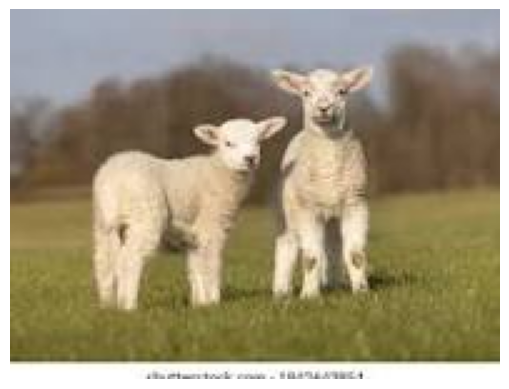

In [ ]:
# Assuming your plot_results(im, outputs, class_names) takes:
# - original PIL image,
# - model outputs (dict),
# - class names dictionary
plot_results(im, outputs, class_names=class_names)


In [ ]:
# Suppose you already have a dataset object
image, target = dataset[11]  # index of image you want to see

boxes = target['boxes']
labels = target['labels']

plot_results(image, boxes, labels, class_names)


IndexError: too many indices for tensor of dimension 2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_results(image, boxes, labels, class_names):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0).cpu().numpy())

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, class_names[label], color='white', fontsize=12, backgroundcolor='red')

    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_prediction(img, boxes, labels, scores, threshold=0.5):
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        if score < threshold or label == 20:
            continue
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1*224, y1*224), (x2 - x1)*224, (y2 - y1)*224,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1*224, y1*224, VOC_CLASSES[label], color='white', bbox=dict(facecolor='red'))
    plt.axis('off')
    plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    for img, target in val_loader:
        img = img.to(device)
        output = model(img)
        probs = output['pred_logits'][0].softmax(-1)
        scores, labels = probs.max(-1)
        boxes = output['pred_boxes'][0]

        show_prediction(img[0].cpu(), boxes.cpu(), labels.cpu(), scores.cpu())
        break
